# Tracking a computational experiment: using a multi-conformer database

For this experiment we will use lwreg's ability to register conformers along with molecules

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem import rdDistGeom
import os
import rdkit
print(rdkit.__version__)
%load_ext sql
%config SqlMagic.named_parameters="enabled"

2024.09.5


# Prepare the dataset we're working with

Some data from ChEMBL

In [2]:
import pandas as pd
from io import StringIO
txt = r'''"standard_relation","standard_value","standard_type","pchembl_value","assay_chembl_id","target_chembl_id","canonical_smiles","compound_chembl_id"
">",10000.0,"Ki",,"CHEMBL615807","CHEMBL214","CCN(C)C1CCCc2ccncc12.OC(=O)\C=C/C(=O)O.OC(=O)\C=C/C(=O)O","CHEMBL1794855"
"=",168.0,"Ki",6.78,"CHEMBL615460","CHEMBL214","CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C","CHEMBL278751"
"=",181.0,"Ki",6.74,"CHEMBL615809","CHEMBL214","C(N1CCN(CC1)c2ncccn2)c3c[nH]c(n3)c4ccccc4","CHEMBL103772"
"=",3.9,"Ki",8.41,"CHEMBL615460","CHEMBL214","CCCN1CC[C@@H]2[C@H]1CCc3ccc4ccoc4c23","CHEMBL328107"
"=",1.6,"Ki",8.8,"CHEMBL615756","CHEMBL214","COc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C4)c5csc6ccccc56)Oc12","CHEMBL148860"
"=",210.0,"Ki",6.68,"CHEMBL615460","CHEMBL214","CCCN(CCC)C1CCc2c(C1)ccc3ccoc23","CHEMBL96735"
"=",1.7,"Ki",8.77,"CHEMBL616120","CHEMBL214","CCc1cccc(OC[C@@H](O)CN2CCC3(CC2)OCc4c3ccc5ccccc45)c1","CHEMBL111065"
"=",344.0,"Ki",6.46,"CHEMBL615460","CHEMBL214","CCCN(CCC)C1CCc2c(O)cccc2C1","CHEMBL273273"
"=",127.7,"Ki",6.89,"CHEMBL615756","CHEMBL214","COc1cccc2OC[C@H](CN3C4CCC3C=C(C4)n5ccc6cc(F)ccc56)Oc12","CHEMBL150050"
"=",5.87,"Ki",8.23,"CHEMBL615756","CHEMBL214","CCOc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C4)c5ccc6ccccc6c5)Oc12","CHEMBL151786"
'''
sio = StringIO(txt)
df = pd.read_csv(sio)
df.head()

,standard_relation,standard_value,standard_type,pchembl_value,assay_chembl_id,target_chembl_id,canonical_smiles,compound_chembl_id
0,>,10000.0,Ki,NaN,CHEMBL615807,CHEMBL214,CCN(C)C1CCCc2ccncc12.OC(=O)\C=C/C(=O)O.OC(=O)\...,CHEMBL1794855
1,=,168.0,Ki,6.78,CHEMBL615460,CHEMBL214,CCCN(CCC)[C@@H]1CCc2c(OC)cccc2[C@@H]1C,CHEMBL278751
2,=,181.0,Ki,6.74,CHEMBL615809,CHEMBL214,C(N1CCN(CC1)c2ncccn2)c3c[nH]c(n3)c4ccccc4,CHEMBL103772
3,=,3.9,Ki,8.41,CHEMBL615460,CHEMBL214,CCCN1CC[C@@H]2[C@H]1CCc3ccc4ccoc4c23,CHEMBL328107
4,=,1.6,Ki,8.80,CHEMBL615756,CHEMBL214,COc1cccc2OC[C@H](CN3[C@@H]4CC[C@H]3C[C@@](O)(C...,CHEMBL148860


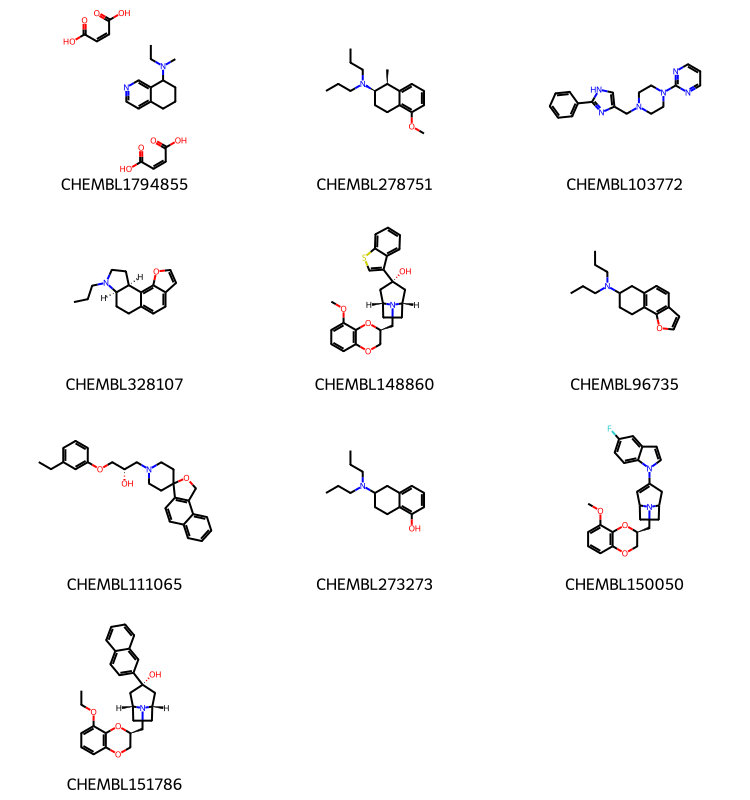

In [3]:
ms = [Chem.MolFromSmiles(smi) for smi in df.canonical_smiles]
Draw.MolsToGridImage(ms,legends=df.compound_chembl_id.to_list(),molsPerRow=3,subImgSize=(250,200))

In [4]:
from rdkit import RDLogger
from rdkit.Chem import rdDistGeom
from rdkit.Chem import rdForceFieldHelpers
from rdkit.Chem.MolStandardize import rdMolStandardize

# find the charge parent for each molecule: keep the largest fragment and neutralize it.
RDLogger.DisableLog('rdApp.info')
for i,m in enumerate(ms):
    ms[i] = Chem.AddHs(rdMolStandardize.ChargeParent(m))
RDLogger.EnableLog('rdApp.info')

# generate conformers for the standardized molecules
params = rdDistGeom.ETKDGv3()
params.randomSeed = 0xf00d
params.numThreads=4
params.pruneRmsThresh = 0.5

for m in ms:
    rdDistGeom.EmbedMultipleConfs(m,5,params=params)
    rdForceFieldHelpers.MMFFOptimizeMoleculeConfs(m,numThreads=4)

Split the multi-conf molecules out into single conf molecules

In [5]:
ms_3d = []
for m in ms:
    for conf in m.GetConformers():
        nm = Chem.Mol(m,confId=conf.GetId())
        ms_3d.append(nm)
len(ms_3d)

47

At this point we have a list of molecules each of which has one conformer

This is the starting point for registration

In [6]:
import lwreg
from lwreg import standardization_lib
from lwreg import utils

config = lwreg.utils.defaultConfig()
# set the name of the database we'll work with:
config['dbname'] = 'lwreg_3dexperiments_demo.sqlite3'
# By the time we load the conformers, the molecules will have already been standardized,
#  so we configure lwreg to not do any standardization
config['standardization'] = 'none'

# tell lwreg that we want to register conformers along with the molecules
config['registerConformers'] = True
lwreg.set_default_config(config)

Initialize the database. **Note** that this erases everything in the current database, so be very careful with this command!

In [7]:
lwreg.initdb()

This will destroy any existing information in the registration database.


  are you sure? [yes/no]:  yes


True

Register all of our compounds/conformers at once:

In [8]:
# now bulk register. We want to also collect IDs of compounds which were already registered.
reg_ids = lwreg.bulk_register(mols=ms_3d,fail_on_duplicate=False)
print(f'Registered {len(reg_ids)} unique conformers.')

Registered 47 unique conformers.


The returned values are (molregno,conf_id) pairs:

In [9]:
reg_ids[:10]

((1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10))

Notice that each molregno can occur multiple times, but the conf_ids are unique

Get the registered mol blocks from lwreg. When `registerConformers` is enabled, as it is here, the registered structure is the first conformer registered for each molecule.

In [10]:
molregnos,conf_ids = zip(*reg_ids)
molregnos = set(molregnos)
molregnos

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

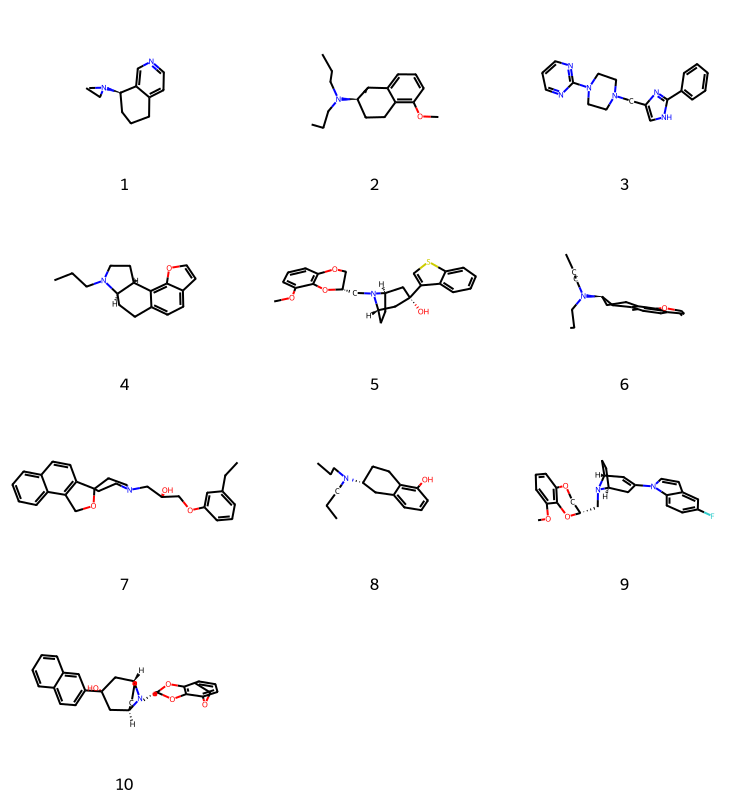

In [11]:
# calling retrieve() with a sequence of molregnos returns the registered structures
mol_data = lwreg.retrieve(ids=molregnos)
mids,new_mols = zip(*[(mid,Chem.MolFromMolBlock(d)) for mid,(d,_) in mol_data.items()])
Draw.MolsToGridImage(new_mols,legends=[str(x) for x in mids],molsPerRow=3,subImgSize=(250,200))

The 2D drawings of the 3D structures don't look so great...

## Generate 3D descriptors

In [12]:
# calling retrieve() with a sequence of (molregno,conf_id) tuples returns conformers
mol_data = lwreg.retrieve(ids=reg_ids)

from rdkit.Chem import Descriptors3D
from rdkit.Chem import rdMolDescriptors
descriptors = {}
extras = {}
for (mrn,cid),(mb,_) in mol_data.items():
    mol = Chem.MolFromMolBlock(mb,removeHs=False)
    descrs = Descriptors3D.CalcMolDescriptors3D(mol)
    # we need to know the names of all the descriptors in order to be able to
    # set up the database table for tracking experimental results
    descrNames = list(descrs.keys())
    descriptors[cid] = list(descrs.values())
    extras[cid] = {'AUTOCORR3D':rdMolDescriptors.CalcAUTOCORR3D(mol),'RDF':rdMolDescriptors.CalcRDF(mol)}

# Set up database to hold experiments and results:

Look at the database config we're using

In [13]:
config

{'dbname': 'lwreg_3dexperiments_demo.sqlite3',
 'dbtype': 'sqlite3',
 'standardization': 'none',
 'removeHs': 1,
 'useTautomerHashv2': 0,
 'registerConformers': True,
 'numConformerDigits': 3,
 'lwregSchema': ''}

Note that the next command wipes out all of the values which are current in the experiments tables

In [14]:
cn = utils.connect(config)
curs = cn.cursor()
# if I were working with postgresql, I'd put the experimental data in a separate
# schema. sqlite doesn't support that
curs.execute('drop table if exists experiments_metadata')
curs.execute('create table experiments_metadata (expt_uid text primary key,metadata jsonb)')
curs.execute('drop table if exists experiments_data')

# add columns for each of the descriptors to our experiments table:
descrCols = ','.join(f'{nm} double' for nm in descrNames)

curs.execute(f'create table experiments_data (result_id integer primary key,expt_uid text not null,conf_id int not null,{descrCols},data jsonb)')
cn.commit()

In [15]:
from datetime import datetime
def non_default_params_to_dict(obj,defaults):
    res = {}
    for k in dir(obj):
        if k.startswith('__'):
            continue
        v = getattr(obj,k)
        if callable(v):
            continue
        if v == getattr(defaults,k):
            continue
        else:
            res[k] = v
    return res


# Capture info about the conformer generation

Register the experiment

In [16]:
from datetime import datetime
dg_metadata = non_default_params_to_dict(params,rdDistGeom.ETKDGv3())

cg_expt_metadata = {
    'Experiment Type':'Conformer generation',
    'Method': 'ETKDGv3',
    'RDKit Version': rdkit.__version__,
    'Date': str(datetime.now()),
    'target_num_conformers':5,
    'note':'conformer generation then MMFF94 minimization'
}
cg_expt_metadata.update(dg_metadata)

In [17]:
import json
import uuid
cg_expt_uid = str(uuid.uuid4())
curs.execute('insert into experiments_metadata values (?,?)',(str(cg_expt_uid),json.dumps(cg_expt_metadata)))
cn.commit()

Now store the "data" from the conformer generation. 

Notice that here we're just storing the association between the experiment and the conformer id. We leave the rest of the fields in the table blank. Storing this data allows us to later figure out how a particular set of conformers was generated.

In [18]:
rows = [(cg_expt_uid,cid) for cid in conf_ids]
curs.executemany('insert into experiments_data (expt_uid,conf_id) values (?,?)',rows)
cn.commit()

# Capture info about the 3D descriptor calculation along with the descriptor values

In [19]:
dc_expt_metadata = {
    'Experiment Type':'3D descriptor calculation',
    'RDKit Version': rdkit.__version__,
    'Date': str(datetime.now()),
}
dc_expt_uid = str(uuid.uuid4())
curs.execute('insert into experiments_metadata values (?,?)',(str(dc_expt_uid),json.dumps(dc_expt_metadata)))
cn.commit()

In [20]:
descrCols

'PMI1 double,PMI2 double,PMI3 double,NPR1 double,NPR2 double,RadiusOfGyration double,InertialShapeFactor double,Eccentricity double,Asphericity double,SpherocityIndex double,PBF double'

In [21]:
rows = []
for cid in conf_ids:
    # start each row with a None that will be filled with the primary key for the table
    row = [None,dc_expt_uid,cid]+descriptors[cid]+[json.dumps(extras[cid])]
    rows.append(row)
qs = ','.join('?'*len(row))
curs.executemany(f'insert into experiments_data values ({qs})',rows)
cn.commit()

In [22]:
len(rows)

47

## Some queries

All of the rows from the descriptor calculation experiment, ordered by the Asphericity value

In [23]:
d = %sql sqlite:///lwreg_3dexperiments_demo.sqlite3 \
    select * from experiments_data \
    where expt_uid=:dc_expt_uid \
        order by Asphericity desc;
len(d)

Connecting to 'sqlite:///lwreg_3dexperiments_demo.sqlite3'

47

The sql magic is nice and gives us the names of the columns:

In [24]:
d.keys

RMKeyView(['result_id', 'expt_uid', 'conf_id', 'PMI1', 'PMI2', 'PMI3', 'NPR1', 'NPR2', 'RadiusOfGyration', 'InertialShapeFactor', 'Eccentricity', 'Asphericity', 'SpherocityIndex', 'PBF', 'data'])

Some plotting

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('tableau-colorblind10')

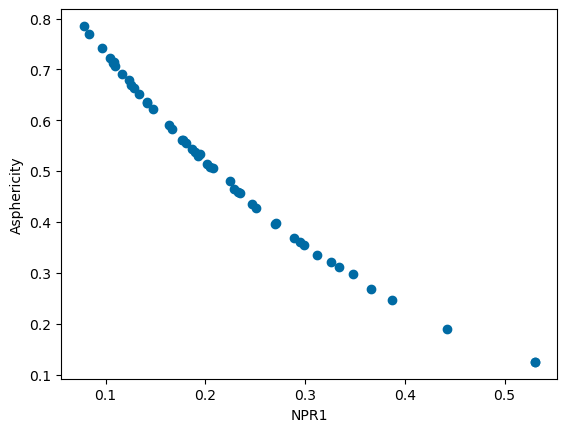

In [26]:
plt.scatter([x.NPR1 for x in d],[x.Asphericity for x in d]);
plt.xlabel('NPR1');
plt.ylabel('Asphericity');

Demonstrate working with descriptors like RDF, which are stored in the JSON object.
RDF is a vector, so we use here the first element

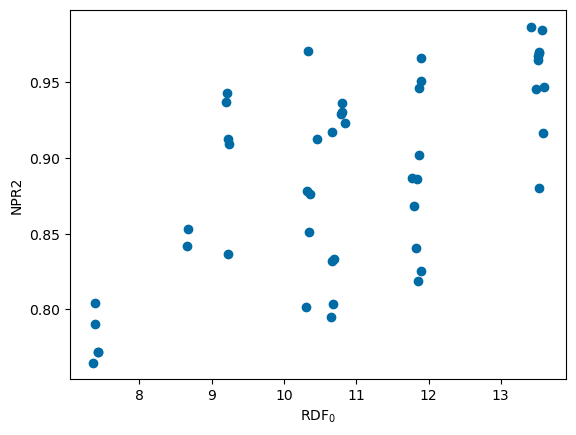

In [27]:
plt.scatter([json.loads(x.data)['RDF'][0] for x in d],[x.NPR2 for x in d]);

plt.xlabel('RDF$_0$');
plt.ylabel('NPR2');

Look at the conformers with the highest and lowest values of NPR1:

In [28]:
d = %sql sqlite:///lwreg_3dexperiments_demo.sqlite3 \
    select conf_id,NPR1,molblock from experiments_data \
      join conformers using (conf_id) \
    where expt_uid=:dc_expt_uid \
        order by NPR1 desc;
len(d)

47

The highest value:

0.5304239757029396


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

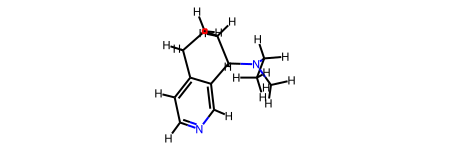

In [29]:
IPythonConsole.ipython_3d = True
print(d[0][1])
Chem.MolFromMolBlock(d[0][2],removeHs=False)

The lowest value

0.07833006820149481


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

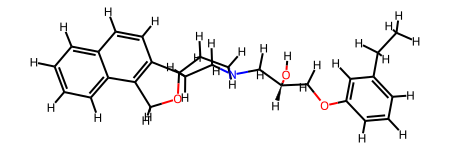

In [30]:
print(d[-1][1])
Chem.MolFromMolBlock(d[-1][2],removeHs=False)

Look at the conformers with the highest and lowest values of NPR2:

In [31]:
d = %sql sqlite:///lwreg_3dexperiments_demo.sqlite3 \
    select conf_id,NPR2,molblock from experiments_data \
      join conformers using (conf_id) \
    where expt_uid=:dc_expt_uid \
        order by NPR2 desc;
len(d)

47

0.9868686317334817


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

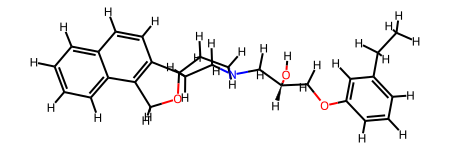

In [32]:
IPythonConsole.ipython_3d = True
print(d[0][1])
Chem.MolFromMolBlock(d[0][2],removeHs=False)

0.7649663185901957


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

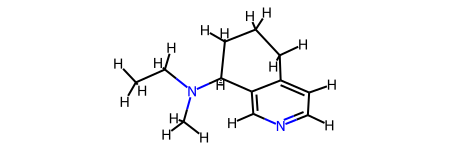

In [33]:
IPythonConsole.ipython_3d = True
print(d[-1][1])
Chem.MolFromMolBlock(d[-1][2],removeHs=False)